In [6]:
import pandas
import numpy as np

tr = pandas.read_csv('train.csv')
te = pandas.read_csv('test.csv')
prd = pandas.read_csv('pred.csv')
get_dirty = lambda df:df[(df.uid == None) | (df.iid == None) | (df.score == None) | (df.score > 5.0) | (df.score < 1.0)]
print(get_dirty(tr),get_dirty(te),get_dirty(prd))
#输出发现没有脏数据
cut = lambda df:df[['uid','iid','score']].drop_duplicates().dropna()
#丢弃重复和nan的数值，只保留前三列
tr,te = cut(tr),cut(te)

Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: [] Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: [] Empty DataFrame
Columns: [uid, iid, score, review, date]
Index: []


In [106]:
from math import sqrt
import matplotlib.pyplot as plt
from collections import defaultdict

class LFM:
    def __init__(self,df,k=5,norm = 0.01): #norm为正则化项中的lambda
        self.r = np.mat(np.zeros((int(df[['uid']].max())+1,int(df[['iid']].max())+1))) #user-item评分矩阵
        self.i2u,self.u2i = defaultdict(set),defaultdict(set) #user-item倒排表与item-user倒排表
        for idx,row in tr.iterrows():
            uid,iid,score = int(row['uid']),int(row['iid']),row['score']
            self.r[uid,iid] = score
            self.u2i[uid].add(iid)
            self.i2u[iid].add(uid)
        self.k,self.norm = k,norm
        self.u = np.mat(np.random.uniform(sqrt(1/k),sqrt(5/k),(self.r.shape[0],k))) #预测评分矩阵=u*i
        self.i = np.mat(np.random.uniform(sqrt(1/k),sqrt(5/k),(self.r.shape[1],k)))

    def loss(self): #损失函数
        ret = self.norm * (np.sum(np.square(self.u)) + np.sum(np.square(self.i)))
        pred_r = self.u * self.i.T
        for i in range(self.r.shape[0]):
            for j in range(self.r.shape[1]):
                if self.r[i,j] != 0:
                    ret += (self.r[i,j] - pred_r[i,j]) ** 2
        return ret
    
    def grad_fit(self,lr = 0.01,maxd = 15,th = 100): #梯度下降，lr为学习率，maxd为最大迭代深度，th为阈值
        d = 0
        x = []
        loss_val = []
        train_score = []
        val_score = []
        while d < maxd and self.loss() > th:
            for uid in range(1,self.r.shape[0]):
                grad = 2 * self.norm * self.u[uid]
                for iid in self.u2i[uid]:
                    grad = grad - 2 * (self.r[uid,iid] - self.u[uid] * self.i[iid].T) * self.i[iid] 
                self.u[uid] = self.u[uid] - lr * grad
            for iid in range(1,self.r.shape[1]):
                grad = 2 * self.norm * self.i[iid]
                for uid in self.i2u[iid]:
                    grad = grad - 2 * (self.r[uid,iid] - self.u[uid] * self.i[iid].T) * self.u[uid] 
                self.i[iid] = self.i[iid] - lr * grad
            x.append(d)
            loss_val.append(self.loss())
            train_score.append(self.rmse_score(tr))
            val_score.append(self.rmse_score(te))
            d += 1
        return x,loss_val,train_score,val_score
    
    def als_fit(self,maxd = 25,th = 100): #交替最小二乘，maxd为最大迭代深度，th为阈值
        d = 0
        x = []
        loss_val = []
        train_score = []
        val_score = []
        while d < maxd and self.loss() > th:
            for uid in range(1,self.r.shape[0]):
                left = np.mat(np.zeros((1,self.k)))
                right = np.mat(np.zeros((self.k,self.k)))
                for iid in self.u2i[uid]:
                    right += self.i[iid].T * self.i[iid]
                    left += self.r[uid,iid] * self.i[iid]
                right += self.norm * np.identity(self.k)
                if abs(np.linalg.det(right)) < 1e-6:
                    self.u[uid] = left * np.linalg.pinv(right + self.norm * np.identity(self.k)) 
                else:
                    self.u[uid] = left * np.linalg.inv(right + self.norm * np.identity(self.k))  
                #考虑到可能出现奇异矩阵，采用moore-penrose伪逆
            for iid in range(1,self.r.shape[1]):
                left = np.mat(np.zeros((1,self.k)))
                right = np.mat(np.zeros((self.k,self.k)))
                for uid in self.i2u[iid]:
                    right += self.u[uid].T * self.u[uid]
                    left += self.r[uid,iid] * self.u[uid]
                right += self.norm * np.identity(self.k)
                if abs(np.linalg.det(right)) < 1e-6:
                    self.i[iid] = left * np.linalg.pinv(right + self.norm * np.identity(self.k)) 
                else:
                    self.i[iid] = left * np.linalg.inv(right + self.norm * np.identity(self.k))  
                #考虑到可能出现奇异矩阵，采用moore-penrose伪逆
            x.append(d)
            loss_val.append(self.loss())
            train_score.append(self.rmse_score(tr))
            val_score.append(self.rmse_score(te))
            d += 1
        return x,loss_val,train_score,val_score
    
    def rmse_score(self,df):
        r = 0
        n = 0
        pred_r = self.u * self.i.T
        for idx,row in df.iterrows():
            uid,iid,score = int(row['uid']),int(row['iid']),row['score']
            if uid < pred_r.shape[0] and iid < pred_r.shape[1]:
                r += (pred_r[uid,iid] - score) ** 2
                n += 1
        return sqrt(r/n)
    
    def pred(self,df):
        ans = []
        pred_r = self.u * self.i.T
        for idx,row in prd.iterrows():
            uid,iid = int(row['uid']),int(row['iid'])
            if uid < pred_r.shape[0] and iid < pred_r.shape[1]:
                ans.append(pred_r[uid,iid])
            else:
                ans.append(3)
        return ans

In [107]:
model = LFM(tr)
x,loss_val,train_score,val_score = model.grad_fit()

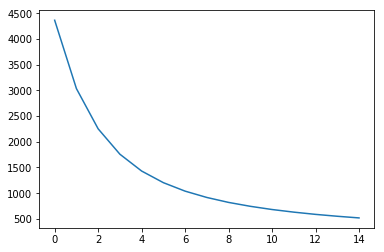

In [108]:
import matplotlib.pyplot as plt
plt.plot(x,loss_val)

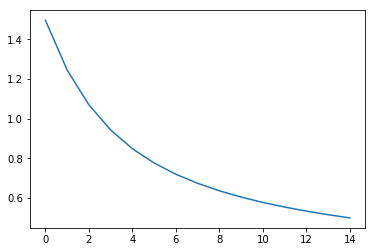

In [109]:
plt.plot(x,train_score)

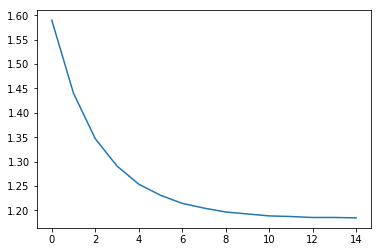

In [110]:
plt.plot(x,val_score)

In [111]:
model.rmse_score(te)

1.1847390114315492

In [112]:
ans = model.pred(prd)
prd['score'] = ans
prd.to_csv('my_answer3.csv')